# Análise de Vendas de Produtos no Varejo

Neste notebook vou analisar as vendas de um fornecedor de produtos. 

Primeiro crio uma função para ler os arquivos, que têm um separador e um encoding difernte do padrão.

In [60]:
import pandas as pd
import matplotlib.pyplot as plt


def ler(arq):
  """Função para ler os arquivos do CDD diário. Separador = |. Encoding = latin1."""


  df = pd.read_csv(arq, sep='|', encoding='latin1')

  return df

Extraio o conteúd do arquivo compactado para uma pasta no Drive.

In [39]:
arq = '/content/drive/MyDrive/datasets/dados.zip'

import zipfile

with zipfile.ZipFile(arq,"r") as Zip_ref:
    Zip_ref.extractall("/content/drive/MyDrive/datasets/")

Leio os arquivos e salvo em diferentes variáveis.

In [142]:
flat = ler('/content/drive/MyDrive/datasets/cdd_00042_000_ff_cup_d.csv')
apres = ler('/content/drive/MyDrive/datasets/cdd_cat_apres.csv')
canal = ler('/content/drive/MyDrive/datasets/cdd_cat_canal.csv')
pdv = ler('/content/drive/MyDrive/datasets/cdd_cat_pdvs.csv')
prod = ler('/content/drive/MyDrive/datasets/cdd_cat_prod.csv')

Faço uma limpeza nos datasets. Os dados têm alguns erros. Também seleciono apenas os dados de fevereiro de 2022.

In [143]:
flat.COD_ANOMESDIA = pd.to_datetime(flat.COD_ANOMESDIA, format='%Y%m%d')
flat[['UND', 'R$', 'R$PCF']] = flat[['UND', 'R$','R$PCF']] / 1000
flat = flat.query("COD_TIPO_TRANSACAO <= 2")
flat.set_index('COD_ANOMESDIA', inplace=True)
canal = canal.query("COD_CANAL == 1")

Faço um merge dos datasets, criando o dataframe **fevereiro**. Aproveito para selecionar apenas as colunas que vou utilizar na análise.

In [136]:
fevereiro = flat.loc["2022-02"].reset_index().merge(apres).merge(pdv).merge(canal).merge(prod)[['COD_ANOMESDIA','COD_PDV','UND',	
                                                                   'R$PCF', 'COD_MARCA','CIDADE',	'UF']]

#Transformar os código em valores categóricos
fevereiro[['COD_PDV', 'COD_MARCA']] = fevereiro[['COD_PDV', 'COD_MARCA']].astype('category')

Podemos ver que as colunas contêm as seguintes informações:


*   COD_ANOMESDIA: Data da venda
*   COD_PDV: Ponto de Venda
* UND: Unidades vendidas
* R$PCF: Preço do produto
* COD_MARCA: Marca do produto
* CIDADE: Cidade do ponto de venda
* UF: Estado do ponto de venda



In [79]:
fevereiro.head(1)

,COD_ANOMESDIA,COD_PDV,UND,R$PCF,COD_MARCA,CIDADE,UF
0,2022-02-16,244400,2.0,79.202,45386,MANAUS,AM


Primeiro, vou ver um resumo do desempenho em Fevereiro.

In [80]:
unidades_vendidas = fevereiro.UND.sum()
receita = fevereiro['R$PCF'].sum()
ticket_medio = receita / unidades_vendidas

quantidade_pdvs = len(fevereiro.COD_PDV.unique())
quantidade_produtos = len(fevereiro.COD_MARCA.unique())

metricas = pd.DataFrame({"Métrica":["Unidades Vendidas", "Receita Bruta (R$)", "Ticket Médio (R$)", "nº de PDVS", "nº de Produtos"],
                         "Valor":[unidades_vendidas, round(receita, 2), round(ticket_medio, 2), quantidade_pdvs, quantidade_produtos]})
metricas

,Métrica,Valor
0,Unidades Vendidas,102374.00
1,Receita Bruta (R$),2374474.35
2,Ticket Médio (R$),23.19
3,nº de PDVS,9095.00
4,nº de Produtos,32.00


Vamos ver quais as **10 marcas mais vendidas** em Fevereiro.

A marca 4743 vendeu quase o dobro da 2ª colocada.

In [81]:
fevereiro.groupby('COD_MARCA').sum()[['UND']].sort_values('UND', ascending=False)[:10]

,UND
COD_MARCA,
4743,32241.0
3094,15043.0
1083,14849.0
1064,6058.0
1143,5981.0
9280,5130.0
10955,4584.0
6996,3677.0
3749,3211.0


Os Pontos de Vendas que mais venderam foram:

In [82]:
fevereiro.groupby('COD_PDV').sum()[['UND']].sort_values('UND', ascending=False)[:10]

,UND
COD_PDV,
168595,450.0
133346,319.0
903414,312.0
145052,274.0
1990702,266.0
535914,258.0
4175,249.0
152899,214.0
10227,189.0


E os Estados com mais vendas foram:

In [83]:
fevereiro.groupby('UF').sum()[['UND']].sort_values('UND', ascending=False)[:10]

,UND
UF,
MA,19569.0
PA,18675.0
SE,7473.0
SC,7418.0
CE,7417.0
AM,7083.0
PR,4775.0
PB,4695.0
RN,3539.0


Também podemos olhar a evolução das vendas a longo do mês.

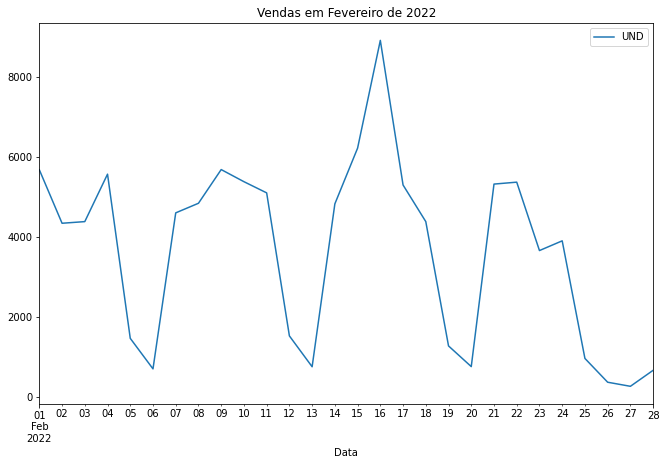

In [84]:
fevereiro.groupby('COD_ANOMESDIA').sum()[['UND']].plot(figsize=(11,7),
                                                       title="Vendas em Fevereiro de 2022",
                                                       xlabel="Data")
plt.show()

Podemos ver que as vendas **caem drasticamente aos fins de semana**:





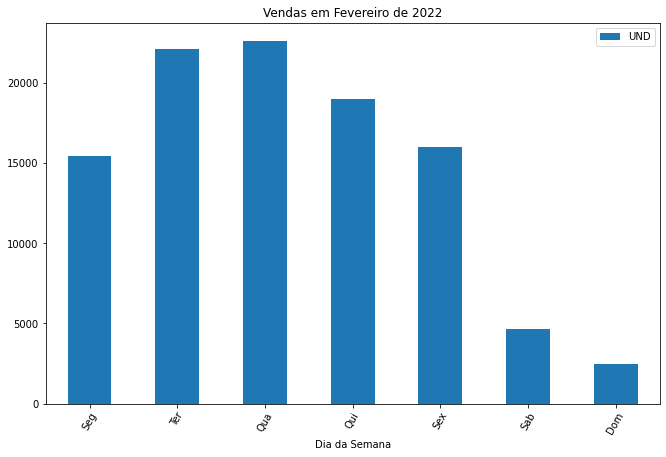

In [112]:
fevereiro['DIA_DA_SEMANA'] = fevereiro.COD_ANOMESDIA.dt.weekday
fevereiro['DIA_DA_SEMANA'] = fevereiro['DIA_DA_SEMANA'].astype('category')

fevereiro.groupby('DIA_DA_SEMANA').sum()[['UND']].plot(kind='bar',figsize=(11,7),
                                                       title="Vendas em Fevereiro de 2022",
                                                       xlabel="Dia da Semana")
plt.xticks([0, 1, 2, 3, 4, 5, 6],
           ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom'], rotation=60)
plt.show()

Por fim, vejamos as **estatísticas descritivas** do conjunto de dados.

In [86]:
fevereiro[['UND','R$PCF']].describe()

,UND,R$PCF
count,44775.000000,44775.000000
mean,2.286410,53.031253
std,4.143022,91.862689
min,-18.000000,-765.376000
25%,1.000000,21.780000
50%,1.000000,34.059000
75%,2.000000,51.222000
max,300.000000,2763.857000


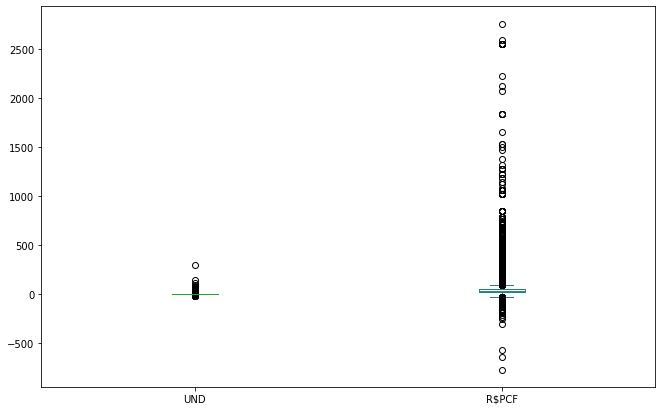

In [87]:
fevereiro[['UND','R$PCF']].plot(kind='box', figsize=(11,7))
plt.show()

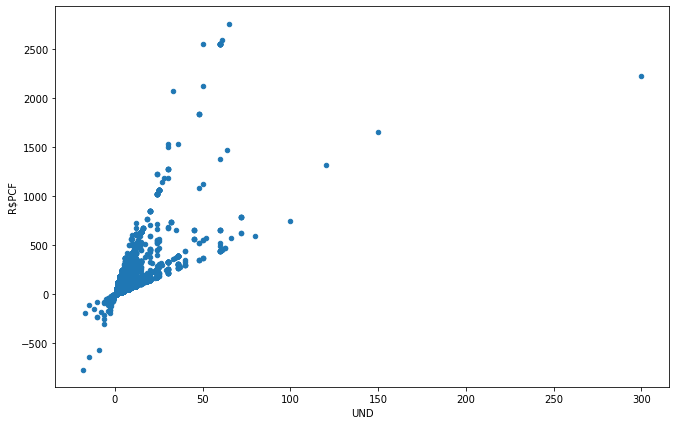

In [88]:
fevereiro[['UND','R$PCF']].plot(kind='scatter', x='UND', y='R$PCF', figsize=(11,7))
plt.show()

Podemos ver que, como era de se esperar, **o Valor aumenta conforme a Quantidade aumenta.**

Também podmes ver que existem **muitos outliers**, principalmente no Valor. Isso tem a ver com compras grandes feitas de um determinado produto.

## Perguntas de Negócio

Com os dados em mãos, vamos tentar responder estas perguntas:

1. Quais os melhores produtos, levando em conta a quantidade de vendas e o ticket médio?

2. Em qual cidade temos os melhores Pontos de Vendas?

3. Qual a previsão de vendas para o próximo mês?

### Criando categorias para os produtos

Para sabermos quais os melhores produtos, temos que classificar eles. Como pedido, vamos levar em consideração a quantidade de unidades vendidas e o ticket médio.

Antes de mais nada, vamos criar um dataframe com o **ticket médio por produto**.

In [89]:
por_produto = fevereiro.groupby('COD_MARCA').sum()[['UND', 'R$PCF']].reset_index()
por_produto['TICKET_MEDIO'] = por_produto['R$PCF'] / por_produto['UND']
por_produto.sort_values('TICKET_MEDIO', ascending=False)

,COD_MARCA,UND,R$PCF,TICKET_MEDIO
23,35892,1165.0,73161.968,62.799973
26,41552,606.0,37044.286,61.129185
25,41550,1044.0,52365.957,50.158963
30,48422,1002.0,50000.833,49.901031
10,7386,289.0,12699.182,43.941806
29,46563,637.0,25999.449,40.815462
28,45386,347.0,13741.602,39.601159
11,7711,402.0,14760.973,36.718838
24,37481,603.0,21394.265,35.479710
8,4743,32241.0,1143860.363,35.478439


Para criar as categorias, vamos ver a participação de cada produto nas vendas totais.

In [90]:
def participacao(und):
  """Recebe as unidades vendidas do produto e retorna sua participação nas vendas totais"""


  return und / unidades_vendidas

In [91]:
por_produto["PARTICIPACAO"] = por_produto['UND'].apply(participacao)

E agora vou criar uma métrica agregada, multiplicando a Participação pelo Ticket Médio. 

In [95]:
por_produto['AGG'] = por_produto['TICKET_MEDIO'] * por_produto['PARTICIPACAO']
por_produto.sort_values('AGG', ascending=False).reset_index(drop=True)

,COD_MARCA,UND,R$PCF,TICKET_MEDIO,PARTICIPACAO,AGG
0,4743,32241.0,1143860.363,35.478439,0.314933,11.173348
1,1143,5981.0,166366.914,27.815903,0.058423,1.625090
2,1083,14849.0,145381.483,9.790658,0.145047,1.420102
3,9280,5130.0,119699.716,23.333278,0.050110,1.169239
4,3094,15043.0,112375.363,7.470276,0.146942,1.097694
5,3749,3211.0,95987.094,29.893209,0.031365,0.937612
6,10955,4584.0,86330.762,18.833063,0.044777,0.843288
7,35892,1165.0,73161.968,62.799973,0.011380,0.714654
8,1064,6058.0,64790.340,10.695005,0.059175,0.632879
9,41550,1044.0,52365.957,50.158963,0.010198,0.511516


Veja que o produto **4743** tem o melhor desempenho disparado. 

Agora, vamos categorizar estes valores para que sejam reprodutíveis. Para isso, vamos usar percentils. 


In [101]:
por_produto.AGG.quantile(.9)

1.162084911207924

As categorias serão as seguintes

* A: AGG > 90%
* B: AGG > 50%
* C: AGG < 50%

In [102]:
def categoria(agg):
  """Recebe um valor de AGG e retorna a categoria que pertence"""

  if agg >= por_produto.AGG.quantile(.9):
    return "A"

  if agg > por_produto.AGG.quantile(.5) and agg < por_produto.AGG.quantile(.9):
    return "B"

  else:
    return "C"

In [105]:
por_produto['CATEGORIA'] = por_produto['AGG'].apply(categoria)

Pronto, agora temos uma tabela com os produtos classificados:

In [109]:
por_produto.sort_values('CATEGORIA')[['COD_MARCA','CATEGORIA']]

,COD_MARCA,CATEGORIA
1,1083,A
2,1143,A
8,4743,A
12,9280,A
0,1064,B
29,46563,B
26,41552,B
25,41550,B
24,37481,B
23,35892,B


Quantidade de produtos por categoria:

In [110]:
por_produto.CATEGORIA.value_counts()

C    16
B    12
A     4
Name: CATEGORIA, dtype: int64

### Pontos de Vendas com mais vendas por Cidade



Primeiro vamos agrupar as vendas por PDV e cidades.

In [116]:
por_pdv = fevereiro.groupby('COD_PDV').sum().reset_index()

In [118]:
por_pdv.sort_values('UND').tail()

,COD_PDV,UND,R$PCF
8692,1990702,266.0,7371.868
4190,145052,274.0,8325.013
6635,903414,312.0,9027.014
3636,133346,319.0,8797.983
4714,168595,450.0,3881.966


In [119]:
cidades = fevereiro[['COD_PDV','CIDADE','UF']]

Vamos pegar os 30 maiores PDVS e ver qual a cidade mais frequente na amostra:

In [128]:
por_pdv.merge(cidades, on='COD_PDV').sort_values('UND', ascending=False).drop_duplicates()[:30].CIDADE.value_counts()

MANAUS                      6
BELEM                       3
BREVES                      3
ARACAJU                     2
ANANINDEUA                  2
BELO JARDIM                 1
CAMETA                      1
NOSSA SENHORA DO SOCORRO    1
IPIRANGA                    1
ALENQUER                    1
ALDEIAS ALTAS               1
ARAME                       1
IMPERATRIZ                  1
CAROLINA                    1
JOAO LISBOA                 1
SAO MIGUEL DO GUAMA         1
IGARAPE-ACU                 1
PAU DOS FERROS              1
WENCESLAU BRAZ              1
Name: CIDADE, dtype: int64

Então Manaus é a cidade com mais PDVS no top 30.

Mas se considerarmos o top 10, Belém é a cidade com mais PDVs.

In [129]:
por_pdv.merge(cidades, on='COD_PDV').sort_values('UND', ascending=False).drop_duplicates()[:10].CIDADE.value_counts()

BELEM                  2
BELO JARDIM            1
ANANINDEUA             1
PAU DOS FERROS         1
IGARAPE-ACU            1
MANAUS                 1
SAO MIGUEL DO GUAMA    1
JOAO LISBOA            1
CAROLINA               1
Name: CIDADE, dtype: int64

Neste caso, precisamos que o time de negócios especifique melhor o cenário com o qual estão trabalhando, para que a análise não gere dúvidas.

### Previsão de vendas

Para fazer uma previsão de vendas, os dados de 1 mês só não são suficientes. Vamos ver qual o periodo que temos dados disponíveis.

In [147]:
flat.reset_index(inplace=True)
flat.COD_ANOMESDIA.describe(datetime_is_numeric=True)

count                           170198
mean     2022-01-11 05:37:47.180577536
min                2021-11-29 00:00:00
25%                2021-12-20 00:00:00
50%                2022-01-12 00:00:00
75%                2022-02-02 00:00:00
max                2022-02-28 00:00:00
Name: COD_ANOMESDIA, dtype: object

OK, temos dados dos últimos 3 meses. 

Para fazer a previsão temos muitas possibilidades. Eu vou utilizar o algoritmo **ARIMA**.

In [153]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import numpy as np

In [156]:
df = flat.merge(apres).merge(pdv).merge(canal)[['COD_ANOMESDIA', 'UND']]
df.columns = ['dt', 'un']
df = df.groupby('dt').sum()
df.head(1)

,un
dt,
2021-11-29,4471.0


In [157]:
ts = np.log(df)

In [170]:
decomposition = seasonal_decompose(ts) 
model = ARIMA(ts, order=(2,1,2))
results = model.fit(disp=-1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


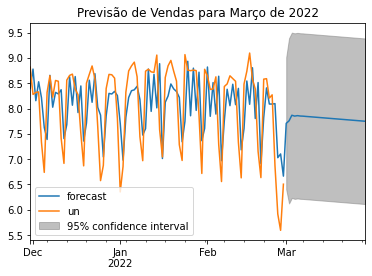

In [180]:
results.plot_predict(1,120)
plt.title("Previsão de Vendas para Março de 2022")
plt.show()

Nossa previsão indica uma leve tendência de queda nas vendas em Março.